# **Generate CSV dataset file**

**Need to use a V100 32GB GPU**

In [29]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from lynx_id.utils.preprocess.utils import flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from md_utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

%matplotlib inline

**Warning: after 90 days of non-use, files are deleted from the SCRATCH.**

In [31]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")

## **Slovenian dataset**

In [4]:
SLOVENIA_DATASET_PATH = DATASET / "slovenia/Slovenia_Krofel"

In [5]:
dataset_dict = {
    "filepath": [],
    "lynx_id": [],
    "date": [],
    "location": [],
    "longitude": [],
    "latitude": [],
    "country": [],
    "sex": [],
}

In [6]:
cnt_individuals = 0

for current_directory, _, files in os.walk(SLOVENIA_DATASET_PATH):
    for file in files:
        absolute_path = os.path.abspath(os.path.join(current_directory, file))
        if absolute_path.endswith(".csv") and 'Doru' not in absolute_path:  # 1 csv = 1 individual
            cnt_individuals += 1
            # Extract data from the CSV
            individual_csv = pd.read_csv(absolute_path, encoding='ISO-8859-1')
            
            # Get filepath
            filepaths = individual_csv['Encounter.mediaAsset0']
            filepaths = filepaths.apply(lambda filepath: current_directory + "/" + Path(file).stem + "/" + filepath.replace(" ", ""))
            # Get date
            dates = pd.to_datetime(individual_csv['Encounter.year'].astype(str) + '-' + individual_csv['Encounter.month'].astype(str) + '-' + individual_csv['Encounter.day'].astype(str) + ' ' + individual_csv['Encounter.hour'].astype(str) + ':' + individual_csv['Encounter.minutes'].astype(str))

            dataset_dict["filepath"].extend(filepaths.tolist())
            dataset_dict["lynx_id"].extend(individual_csv['MarkedIndividual.nickname'].tolist())
            dataset_dict["date"].extend(dates.tolist())
            dataset_dict["location"].extend(individual_csv['Encounter.verbatimLocality'].tolist())  # locationID is always the same: Dinarides
            dataset_dict["longitude"].extend(individual_csv['Encounter.decimalLongitude'].tolist())
            dataset_dict["latitude"].extend(individual_csv['Encounter.decimalLatitude'].tolist())
            dataset_dict["country"].extend(individual_csv['Encounter.country'].tolist())
            dataset_dict["sex"].extend(individual_csv['Encounter.sex'].tolist())

print(f"{cnt_individuals=}")
# individual_csv

cnt_individuals=52


In [7]:
df_slovenia = pd.DataFrame(dataset_dict)
df_slovenia

filepath lynx_id  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
...                                                 ...     ...   
2025  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
2026  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
2027  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
2028  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
2029  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   

                    date    location  longitude  latitude   country   sex  
0    2021-08-29 18:37:00      LD_Col    14.1033   45.8814  Slovenia  Male  
1    2021-10-30 10:05:00  LD_Bukovje    14.0924   45.8225  Slovenia  Male  
2    2022-01-23 15:06:00      LD_Col    14.1033   45.8814  Slovenia  Male  
3    2022-03-02 15:54:00      LD_Col    14.1033   45.8814  Slovenia  Male  
4    2022-03-02 15:54:00      LD_Col    14.1033   45.8814  Slovenia  Male  
...                  ...         ...        ...       ...       ...   ...  
2025 2022-11-26 12:49:00  LD_Ribnica    14.7730   45.7510  Slovenia  Male  
2026 2023-04-17 14:59:00  LD_Ribnica    14.7730   45.7510  Slovenia  Male  
2027 2022-11-27 11:03:00  LD_Ribnica    14.7730   45.7510  Slovenia  Male  
2028 2023-02-06 00:21:00  LD_Ribnica    14.7349   45.7776  Slovenia  Male  
2029 2023-04-13 03:45:00   LD_Struge    14.7829   45.7624  Slovenia  Male  

[2030 rows x 8 columns]

In [8]:
df_slovenia["sex"].value_counts()

sex
Male      1391
Female     580
Name: count, dtype: int64

In [9]:
all_files_exist = all(df_slovenia['filepath'].apply(os.path.exists))
all_files_exist

True

#### Bounding box detection

In [10]:
slovenia_output_megadetector = DATASET / "bbox_slovenia.json"  # WARNING: change filename if needed

In [11]:
image_filenames = path_utils.find_images(SLOVENIA_DATASET_PATH, recursive=True)
image_filenames=[file for file in image_filenames if "Doru" not in file]
len(image_filenames)

2027

In [12]:
df_slovenia['filepath'].nunique()

2027

In [13]:
results = load_and_run_detector_batch(
    model_file='/gpfswork/rech/ads/commun/megadetector/md_v5a.0.0.pt', 
    image_file_names=image_filenames, 
    quiet=True, 
    include_image_size=True, 
    confidence_threshold=0.5
)

output = write_results_to_file(results, slovenia_output_megadetector)

PyTorch reports 1 available CUDA devices
GPU available: True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Imported YOLOv5 as utils.*
Using PyTorch version 2.1.1


Fusing layers... 
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


Sending model to GPU
Loaded model in 20.64 seconds
Loaded model in 20.64 seconds


100%|██████████| 2027/2027 [05:55<00:00,  5.71it/s]


Output file saved at /gpfsscratch/rech/ads/commun/datasets/extracted/bbox_slovenia.json


In [14]:
with open(slovenia_output_megadetector, 'r') as f:
    bbox_slovenia = json.load(f)

Some images may not have bounding boxes found.

In [15]:
no_bbox_slovenia, multiple_bbox_slovenia = get_no_and_multiple_bbox(bbox_slovenia)

55 images have no bounding boxes detected.
20 images have several bounding boxes detected.
Total: 2027 images.


Sometimes the length is not identical between `bbox_slovenia` and `df_slovenia`. To do this, we look for differences.

In [16]:
all_file_megadetector = []
for img in bbox_slovenia['images']:
    all_file_megadetector.append(img['file']) 
print(len(all_file_megadetector))

all_file_df_slovenia = df_slovenia['filepath'].to_list()
print(len(all_file_df_slovenia))

2027
2030


In [17]:
set(all_file_megadetector) - set(all_file_df_slovenia)

set()

In [18]:
set(all_file_df_slovenia) - set(all_file_megadetector)

set()

Back to bbox...

In [19]:
df_bbox_slovenia = flatten_bbox(bbox_slovenia, add_image_without_bbox=False, verbose=False)
df_bbox_slovenia

file  im_width  im_height  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...      2048       1440   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...      5376       3024   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...      5376       3024   
...                                                 ...       ...        ...   
1987  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1988  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1989  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1990  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1991  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   

     category   conf       x       y   width  height  
0           1  0.937  0.8874  0.4589  0.1125  0.2643  
1           1  0.940  0.2001  0.4516  0.2018  0.2084  
2           1  0.955  0.0000  0.5472  0.1538  0.1569  
3           1  0.954  0.1199  0.4543  0.1793  0.1812  
4           1  0.883  0.6649  0.5162  0.1149  0.1679  
...       ...    ...     ...     ...     ...     ...  
1987        1  0.906  0.5576  0.4185  0.2907  0.3195  
1988        1  0.941  0.6446  0.4684  0.3084  0.5000  
1989        1  0.908  0.1502  0.1869  0.2598  0.7784  
1990        1  0.966  0.2191  0.3858  0.4561  0.5801  
1991        1  0.940  0.1915  0.3366  0.2133  0.6305  

[1992 rows x 9 columns]

Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [20]:
df_bbox_slovenia = absolute_coordinates_bbox(df_bbox_slovenia)

df_bbox_slovenia

file  im_width  im_height  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...      2048       1440   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...      5376       3024   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...      5376       3024   
...                                                 ...       ...        ...   
1987  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1988  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1989  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1990  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   
1991  /gpfsscratch/rech/ads/commun/datasets/extracte...      5152       3968   

     category   conf          x          y      width     height  
0           1  0.937  4571.8848  1820.9152   579.6000  1048.7424  
1           1  0.940  1030.9152  1791.9488  1039.6736   826.9312  
2           1  0.955     0.0000   787.9680   314.9824   225.9360  
3           1  0.954   644.5824  1373.8032   963.9168   547.9488  
4           1  0.883  3574.5024  1560.9888   617.7024   507.7296  
...       ...    ...        ...        ...        ...        ...  
1987        1  0.906  2872.7552  1660.6080  1497.6864  1267.7760  
1988        1  0.941  3320.9792  1858.6112  1588.8768  1984.0000  
1989        1  0.908   773.8304   741.6192  1338.4896  3088.6912  
1990        1  0.966  1128.8032  1530.8544  2349.8272  2301.8368  
1991        1  0.940   986.6080  1335.6288  1098.9216  2501.8240  

[1992 rows x 9 columns]

#### 10 images cropped with the least confidence are displayed

Only images with a single bounding box are displayed.

In [21]:
df_bbox_slovenia_single_detection, df_bbox_slovenia_multiple_detections = separate_single_multiple_df(df_bbox_slovenia)

print(len(df_bbox_slovenia_single_detection))
print(len(df_bbox_slovenia_multiple_detections))

1952
40


In [22]:
%matplotlib inline

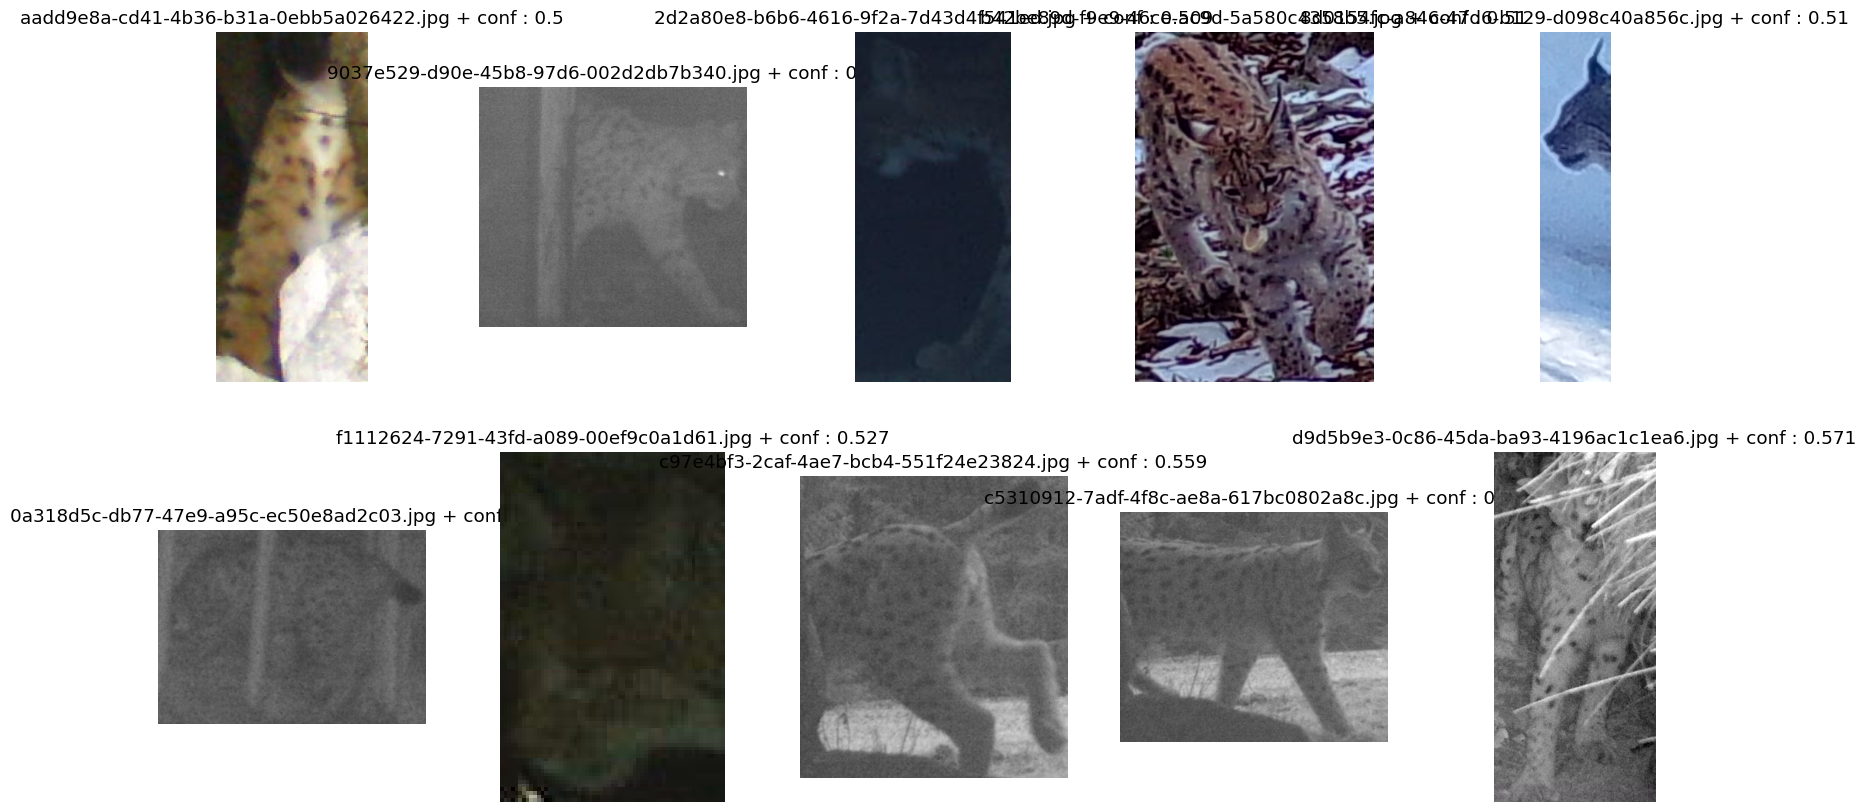

In [23]:
plot_images_conf(df_bbox_slovenia_single_detection, by="smallest")

#### 10 images cropped with the largest confidence are displayed

In [24]:
plot_images_conf(df_bbox_slovenia_single_detection, by="largest")

In [25]:
df_slovenia_with_bbox = pd.merge(df_slovenia, df_bbox_slovenia_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_slovenia_with_bbox = df_slovenia_with_bbox.drop('file', axis=1)

df_slovenia_with_bbox

filepath lynx_id  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
...                                                 ...     ...   
1950  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1951  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1952  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1953  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1954  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   

                    date    location  longitude  ...   conf            x  \
0    2021-08-29 18:37:00      LD_Col    14.1033  ...  0.940   895.932800   
1    2021-10-30 10:05:00  LD_Bukovje    14.0924  ...  0.971  2132.928000   
2    2022-01-23 15:06:00      LD_Col    14.1033  ...  0.965     0.999488   
3    2022-03-02 15:54:00      LD_Col    14.1033  ...  0.954  1584.755200   
4    2022-03-02 15:54:00      LD_Col    14.1033  ...  0.971   285.987520   
...                  ...         ...        ...  ...    ...          ...   
1950 2022-10-09 22:18:00  LD_Ribnica    14.7349  ...  0.953  4685.811200   
1951 2022-11-26 12:49:00  LD_Ribnica    14.7730  ...  0.961  1126.451200   
1952 2023-04-17 14:59:00  LD_Ribnica    14.7730  ...  0.959  4531.520000   
1953 2023-02-06 00:21:00  LD_Ribnica    14.7349  ...  0.917  4902.822400   
1954 2023-04-13 03:45:00   LD_Struge    14.7829  ...  0.963  1360.896000   

              y      width     height  
0     1143.9744  1109.7408   642.8160  
1     1884.8000  1353.9456  1169.7664  
2     1719.7312  1174.6560  1016.9984  
3     1417.7664   996.9120   524.9664  
4     2120.8960  1040.7040   604.7232  
...         ...        ...        ...  
1950  1762.9416  1534.7584   748.9944  
1951  1057.6944  1010.4192   809.6760  
1952  1178.7048  1229.9392   629.7480  
1953  1309.9464  1006.6560   674.9064  
1954   951.9840   686.8992   454.8960  

[1955 rows x 13 columns]

#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

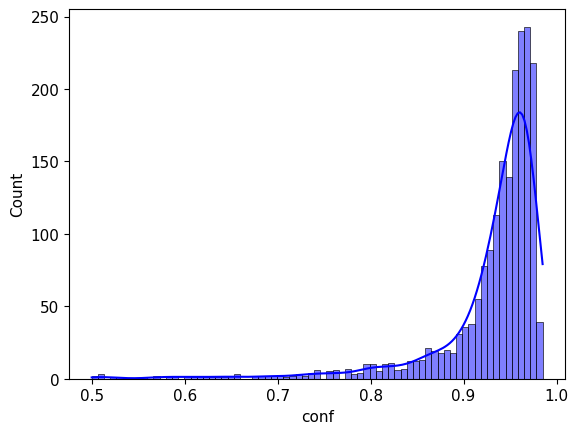

In [26]:
import seaborn as sns

sns.histplot(df_slovenia_with_bbox["conf"], kde=True, color='blue')

#### Compute `image_number` for each individual

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [27]:
df_slovenia_with_bbox['image_number'] = df_slovenia_with_bbox.groupby('lynx_id').cumcount() + 1
df_slovenia_with_bbox

filepath lynx_id  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Nanos1   
...                                                 ...     ...   
1950  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1951  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1952  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1953  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   
1954  /gpfsscratch/rech/ads/commun/datasets/extracte...    Goru   

                    date    location  longitude  ...            x          y  \
0    2021-08-29 18:37:00      LD_Col    14.1033  ...   895.932800  1143.9744   
1    2021-10-30 10:05:00  LD_Bukovje    14.0924  ...  2132.928000  1884.8000   
2    2022-01-23 15:06:00      LD_Col    14.1033  ...     0.999488  1719.7312   
3    2022-03-02 15:54:00      LD_Col    14.1033  ...  1584.755200  1417.7664   
4    2022-03-02 15:54:00      LD_Col    14.1033  ...   285.987520  2120.8960   
...                  ...         ...        ...  ...          ...        ...   
1950 2022-10-09 22:18:00  LD_Ribnica    14.7349  ...  4685.811200  1762.9416   
1951 2022-11-26 12:49:00  LD_Ribnica    14.7730  ...  1126.451200  1057.6944   
1952 2023-04-17 14:59:00  LD_Ribnica    14.7730  ...  4531.520000  1178.7048   
1953 2023-02-06 00:21:00  LD_Ribnica    14.7349  ...  4902.822400  1309.9464   
1954 2023-04-13 03:45:00   LD_Struge    14.7829  ...  1360.896000   951.9840   

          width     height  image_number  
0     1109.7408   642.8160             1  
1     1353.9456  1169.7664             2  
2     1174.6560  1016.9984             3  
3      996.9120   524.9664             4  
4     1040.7040   604.7232             5  
...         ...        ...           ...  
1950  1534.7584   748.9944           459  
1951  1010.4192   809.6760           460  
1952  1229.9392   629.7480           461  
1953  1006.6560   674.9064           462  
1954   686.8992   454.8960           463  

[1955 rows x 14 columns]

In [28]:
df_slovenia_with_bbox.to_csv(DATASET / "slovenia" / "lynx_dataset_slovenia.csv", index=False)

## **French dataset**

In [32]:
FRANCE_DATASET_PATH = DATASET / "france" / "Deep learning lynx - data" / "0_dataset_raw"

### CSV generation

In [33]:
individual_folders = os.listdir(FRANCE_DATASET_PATH)

In [34]:
dataset_dict = {
    "filepath": [],
    "lynx_id": [],
    "source": [],
    "pattern": [],
    "date": [],
    "location": [],
    "image_number": []
}

In [35]:
def parse_filename(filename):
    filename = filename.split(".")[0]
    parts = filename.split("_")
    
    return {"id_lynx": parts[0], "source": parts[1], "pattern": parts[2], "date": parts[3], "location": parts[4], "image_number": parts[5]}

In [36]:
for current_directory, _, files in os.walk(FRANCE_DATASET_PATH):
    if "0_dataset_Marie_3_individus" in current_directory :
        continue

    for file in files:
        absolute_path = os.path.abspath(os.path.join(current_directory, file))
        if file.endswith((".txt", ".xlsx", ".db")):
            continue
        if file.startswith(('broken')):
            print(file)
            continue
        if '.ipynb_checkpoints' in absolute_path:
            print(file)
            continue
            
        try:
            parsed_filename = parse_filename(file)
        except:
            print(absolute_path)  # TODO: problem with these filenames
            continue  # skip them
            
        dataset_dict["filepath"].append(absolute_path)
        dataset_dict["lynx_id"].append(parsed_filename["id_lynx"])
        dataset_dict["source"].append(parsed_filename["source"])
        dataset_dict["pattern"].append(parsed_filename["pattern"])
        dataset_dict["date"].append(parsed_filename["date"])
        dataset_dict["location"].append(parsed_filename["location"])
        dataset_dict["image_number"].append(parsed_filename["image_number"])

broken_FDC01_point_36.2_evosges_le_col_2018_09_01_flanc_droit.JPG
broken_FDC01_point_15.2_corlier_montlier_2019_02_10_flanc_droit_erreur date-F01_047.JPG
broken_1556_FD_2021-05-26-21_100_1-FDC39-Mont-sur-Monnet.jpg
broken_300_2021-05-02-100_1-FDC39-Mont-sur-Monnet.jpg
broken_1556_FD_2021-07-04-21_100_1-FDC39-Mont-sur-Monnet (2).jpg
broken_1556_FG__2021-07-04-21_100_1-FDC39-Mont-sur-Monnet (1).jpg
broken_Villard_F39-038_OFB_OCELLES_2015-03-22_Villard-Saint-Sauveur_4322_03_15.JPG


In [37]:
df_france = pd.DataFrame(dataset_dict)
df_france

filepath   lynx_id source  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
...                                                 ...       ...    ...   
3324  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3325  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3326  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3327  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   
3328  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   

     pattern        date     location image_number  
0         NA  2012-04-27           NA            5  
1         NA  2012-05-05           NA            1  
2         NA  2012-03-17           NA            3  
3         NA  2012-03-16           NA            6  
4         NA  2012-03-05           NA            7  
...      ...         ...          ...          ...  
3324   SPOTS  2015-07-21      Goumois            4  
3325   SPOTS  2015-07-21      Goumois            3  
3326   SPOTS  2015-07-21      Goumois            1  
3327   SPOTS  2017-08-08  Chaux-Neuve            2  
3328   SPOTS  2017-08-08  Chaux-Neuve            1  

[3329 rows x 7 columns]

**Convert the values in the "date" column into datetime**. The format most often found is YYYY-MM-DD but sometimes day and month are reversed. Some other strange dates are also printed (replaced by NaT).
  
**Note**: NA values are replaced by nan values recognised by pd.isna when the csv is saved.

In [38]:
from datetime import datetime

def convert_date(date_str):
    if pd.isna(date_str):
        return None
    try:
        return datetime.strptime(date_str, "%Y-%m-%d")
    except ValueError:
        try:
            return datetime.strptime(date_str, "%Y-%d-%m")
        except ValueError:
            print(date_str)
            return None
        
df_france["date"] = df_france["date"].apply(convert_date)
df_france

NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA
2021
2021
2021-13-13
2021-13-13
NA
NA
NA
NA
NA
NA
NA
NA
NA
NA


filepath   lynx_id source  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
...                                                 ...       ...    ...   
3324  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3325  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3326  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3327  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   
3328  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   

     pattern       date     location image_number  
0         NA 2012-04-27           NA            5  
1         NA 2012-05-05           NA            1  
2         NA 2012-03-17           NA            3  
3         NA 2012-03-16           NA            6  
4         NA 2012-03-05           NA            7  
...      ...        ...          ...          ...  
3324   SPOTS 2015-07-21      Goumois            4  
3325   SPOTS 2015-07-21      Goumois            3  
3326   SPOTS 2015-07-21      Goumois            1  
3327   SPOTS 2017-08-08  Chaux-Neuve            2  
3328   SPOTS 2017-08-08  Chaux-Neuve            1  

[3329 rows x 7 columns]

#### Deleting broken images

In [39]:
all_files_exist = all(df_france['filepath'].apply(os.path.exists))
all_files_exist

True

#### Bounding box detection

In [40]:
france_output_megadetector = DATASET / "france" / "bbox_france.json"  # WARNING: change filename if needed

In [41]:
image_filenames = path_utils.find_images(FRANCE_DATASET_PATH, recursive=True)
image_filenames=[file for file in image_filenames if "3_individus" not in file]
len(image_filenames)

3336

In [42]:
results = load_and_run_detector_batch(
    model_file='/gpfswork/rech/ads/commun/megadetector/md_v5a.0.0.pt', 
    image_file_names=image_filenames, 
    quiet=True, 
    include_image_size=True, 
    confidence_threshold=0.5
)

output = write_results_to_file(results, france_output_megadetector)

PyTorch reports 1 available CUDA devices
GPU available: True


Fusing layers... 
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


Sending model to GPU
Loaded model in 1.72 seconds
Loaded model in 1.72 seconds


100%|██████████| 3336/3336 [06:22<00:00,  8.72it/s]


Output file saved at /gpfsscratch/rech/ads/commun/datasets/extracted/france/bbox_france.json


In [48]:
with open(france_output_megadetector, 'r') as f:
    bbox_france = json.load(f)

Some images may not have bounding boxes found.

In [49]:
no_bbox_france, multiple_bbox_france = get_no_and_multiple_bbox(bbox_france)

33 images have no bounding boxes detected.
215 images have several bounding boxes detected.
Total: 3336 images.


Sometimes the length is not identical between `bbox_france` and `df_france`. To do this, we look for differences.

In [50]:
all_file_megadetector = []
for img in bbox_france['images']:
    all_file_megadetector.append(img['file']) 
print(len(all_file_megadetector))

all_file_df_france = df_france['filepath'].to_list()
print(len(all_file_df_france))

3336
3329


In [51]:
set(all_file_megadetector) - set(all_file_df_france)

{'/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OFB_ocelles/OFB_OCELLES_F01-047=922/broken_FDC01_point_15.2_corlier_montlier_2019_02_10_flanc_droit_erreur date-F01_047.JPG',
 '/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OFB_ocelles/OFB_OCELLES_F01-047=922/broken_FDC01_point_36.2_evosges_le_col_2018_09_01_flanc_droit.JPG',
 '/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OFB_ocelles/OFB_OCELLES_F39-038/broken_Villard_F39-038_OFB_OCELLES_2015-03-22_Villard-Saint-Sauveur_4322_03_15.JPG',
 '/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OFB_ocelles/OFB_OCELLES_F39-095=1556/broken_1556_FD_2021-05-26-21_100_1-FDC39-Mont-sur-Monnet.jpg',
 '/gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_da

In [52]:
set(all_file_df_france) - set(all_file_megadetector)

set()

Back to bbox...

In [53]:
df_bbox_france = flatten_bbox(bbox_france, add_image_without_bbox=False)
df_bbox_france

file  im_width  im_height  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...      1467        950   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...      4608       2592   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...      4608       2592   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...      3840       2160   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...      1142        883   
...                                                 ...       ...        ...   
3542  /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
3543  /gpfsscratch/rech/ads/commun/datasets/extracte...      2048       1536   
3544  /gpfsscratch/rech/ads/commun/datasets/extracte...      2592       2000   
3545  /gpfsscratch/rech/ads/commun/datasets/extracte...      2592       2000   
3546  /gpfsscratch/rech/ads/commun/datasets/extracte...       620        480   

     category   conf        x        y    width  height  
0           1  0.904  0.25760  0.08421  0.48600  0.6726  
1           1  0.958  0.46410  0.41200  0.09092  0.1022  
2           1  0.937  0.20780  0.46060  0.08138  0.1030  
3           1  0.925  0.16790  0.30830  0.37180  0.2865  
4           1  0.960  0.04640  0.09513  0.53590  0.5096  
...       ...    ...      ...      ...      ...     ...  
3542        1  0.936  0.13150  0.41830  0.19480  0.1451  
3543        1  0.951  0.07861  0.42250  0.28270  0.2109  
3544        1  0.953  0.37490  0.35990  0.32630  0.3350  
3545        1  0.958  0.37800  0.47950  0.34680  0.2284  
3546        1  0.942  0.11770  0.06250  0.69830  0.8604  

[3547 rows x 9 columns]

Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [54]:
df_bbox_france = absolute_coordinates_bbox(df_bbox_france)

df_bbox_france

file  im_width  im_height  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...      1467        950   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...      4608       2592   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...      4608       2592   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...      3840       2160   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...      1142        883   
...                                                 ...       ...        ...   
3542  /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
3543  /gpfsscratch/rech/ads/commun/datasets/extracte...      2048       1536   
3544  /gpfsscratch/rech/ads/commun/datasets/extracte...      2592       2000   
3545  /gpfsscratch/rech/ads/commun/datasets/extracte...      2592       2000   
3546  /gpfsscratch/rech/ads/commun/datasets/extracte...       620        480   

     category   conf           x           y       width    height  
0           1  0.904   377.89920    79.99950   712.96200  638.9700  
1           1  0.958  2138.57280  1067.90400   418.95936  264.9024  
2           1  0.937   957.54240  1193.87520   374.99904  266.9760  
3           1  0.925   644.73600   665.92800  1427.71200  618.8400  
4           1  0.960    52.98880    83.99979   611.99780  449.9768  
...       ...    ...         ...         ...         ...       ...  
3542        1  0.936   338.74400   829.90720   501.80480  287.8784  
3543        1  0.951   160.99328   648.96000   578.96960  323.9424  
3544        1  0.953   971.74080   719.80000   845.76960  670.0000  
3545        1  0.958   979.77600   959.00000   898.90560  456.8000  
3546        1  0.942    72.97400    30.00000   432.94600  412.9920  

[3547 rows x 9 columns]

#### 10 images cropped with the least confidence are displayed

Only images with a single bounding box are displayed.

In [55]:
df_bbox_france_single_detection, df_bbox_france_multiple_detections = separate_single_multiple_df(df_bbox_france)

print(len(df_bbox_france_single_detection))
print(len(df_bbox_france_multiple_detections))

3088
459


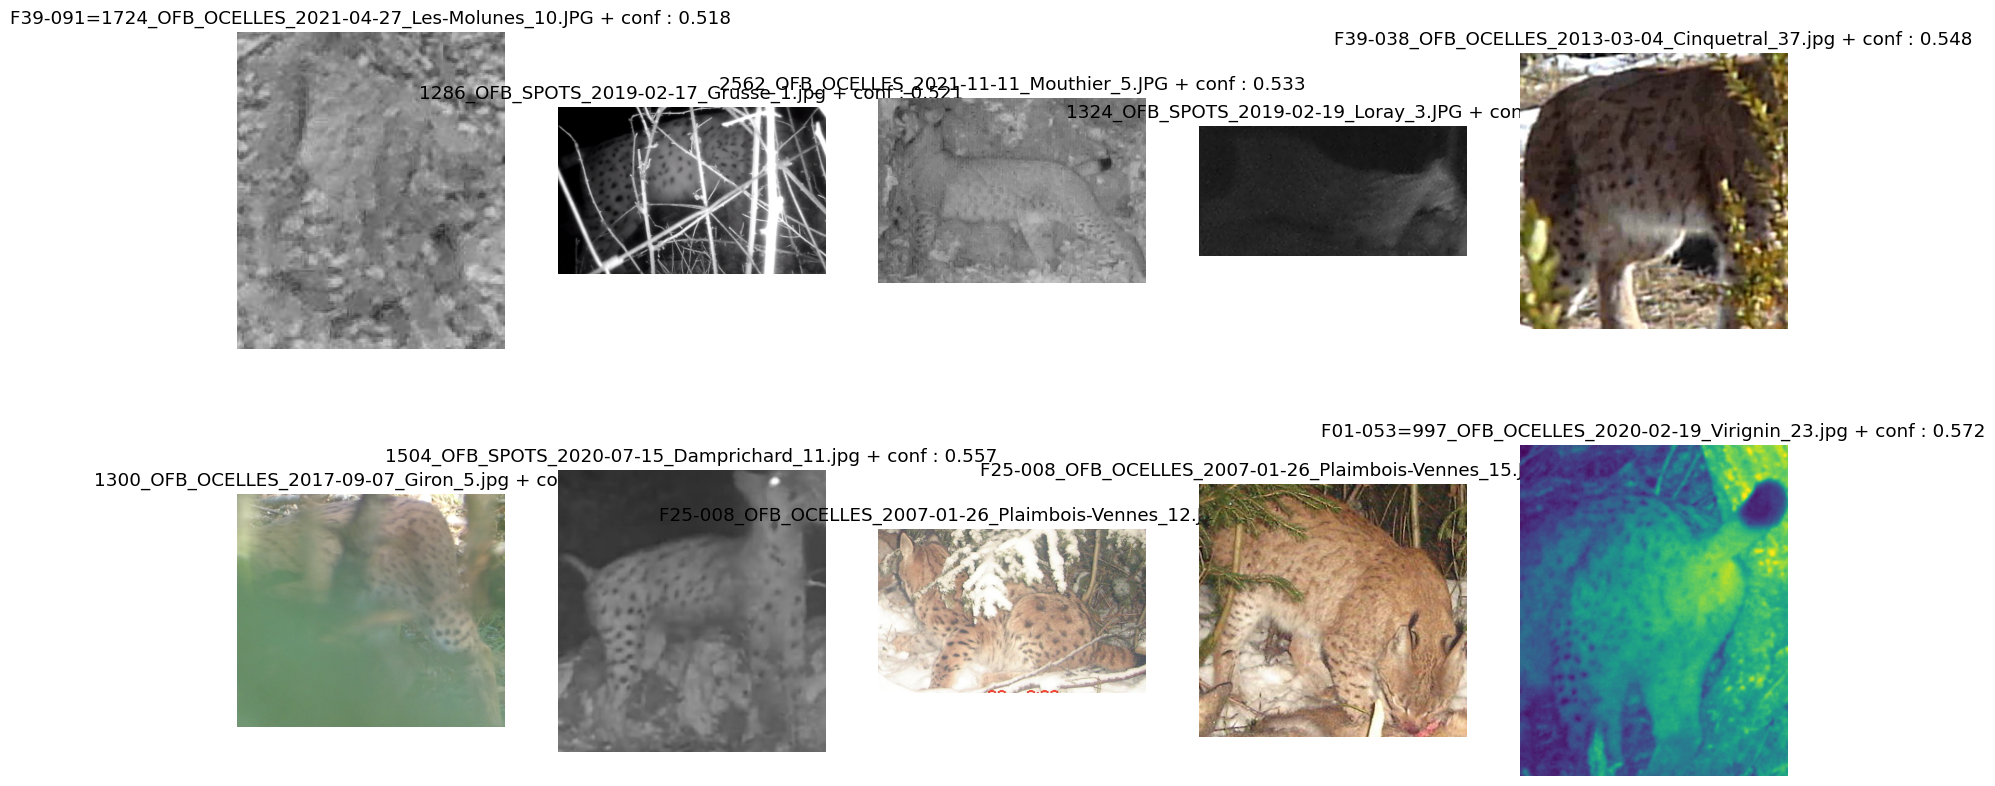

In [56]:
plot_images_conf(df_bbox_france_single_detection, by="smallest")

#### 10 images cropped with the largest confidence are displayed

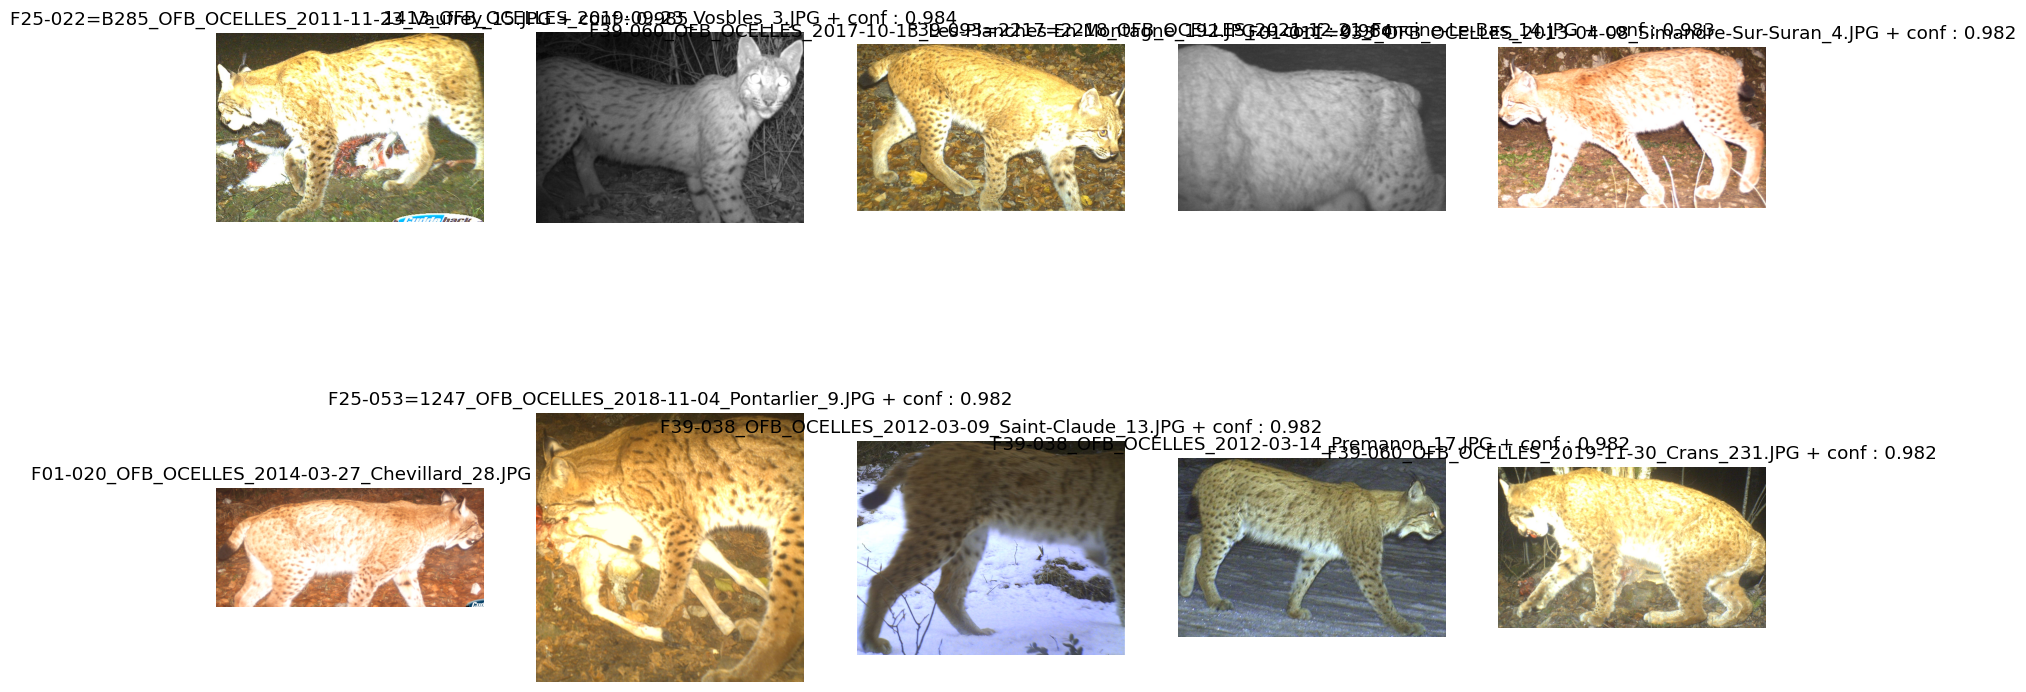

In [57]:
plot_images_conf(df_bbox_france_single_detection, by="largest")

In [58]:
df_france_with_bbox = pd.merge(df_france, df_bbox_france_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_france_with_bbox = df_france_with_bbox.drop('file', axis=1)

df_france_with_bbox

filepath   lynx_id source  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
...                                                 ...       ...    ...   
3076  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3077  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3078  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3079  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   
3080  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   

     pattern       date  ...   conf          x          y      width  \
0         NA 2012-04-27  ...  0.938   854.8416  1054.8000   558.8352   
1         NA 2012-05-05  ...  0.894   906.8544   948.9312   997.7472   
2         NA 2012-03-17  ...  0.939  1192.8384   821.8000   743.9040   
3         NA 2012-03-16  ...  0.965   834.8832   673.8000   594.8640   
4         NA 2012-03-05  ...  0.970   765.9080   315.9860   568.8540   
...      ...        ...  ...    ...        ...        ...        ...   
3076   SPOTS 2015-07-21  ...  0.925   668.7360  1152.9216  3805.5744   
3077   SPOTS 2015-07-21  ...  0.949  1276.8192   880.9344  3906.6624   
3078   SPOTS 2015-07-21  ...  0.902   615.8804   767.9859  1334.8447   
3079   SPOTS 2017-08-08  ...  0.959  1797.7904   835.8592   470.8928   
3080   SPOTS 2017-08-08  ...  0.964   869.9152  1065.8048   345.9568   

         height  
0      289.0000  
1     1628.8128  
2      465.8000  
3      518.8000  
4      392.9500  
...         ...  
3076  2295.8208  
3077  2475.8784  
3078   828.8511  
3079   251.9680  
3080   380.9280  

[3081 rows x 12 columns]

#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

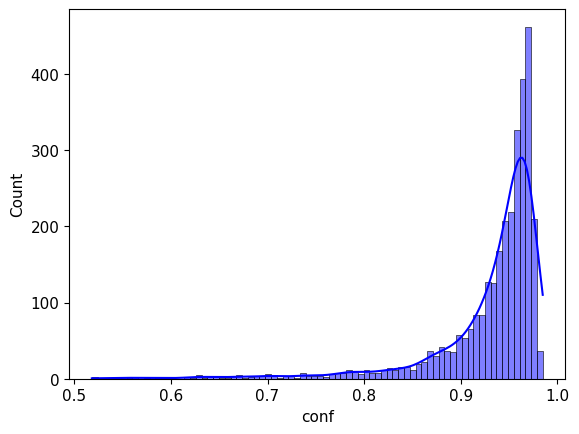

In [59]:
import seaborn as sns

sns.histplot(df_france_with_bbox["conf"], kde=True, color='blue')

#### Compute `image_number` for each individual

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [60]:
df_france_with_bbox['image_number'] = df_france_with_bbox.groupby('lynx_id').cumcount() + 1
df_france_with_bbox

filepath   lynx_id source  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
...                                                 ...       ...    ...   
3076  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3077  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3078  /gpfsscratch/rech/ads/commun/datasets/extracte...  679=L192    OFB   
3079  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   
3080  /gpfsscratch/rech/ads/commun/datasets/extracte...      1017    OFB   

     pattern       date  ...   conf          x          y      width  \
0         NA 2012-04-27  ...  0.938   854.8416  1054.8000   558.8352   
1         NA 2012-05-05  ...  0.894   906.8544   948.9312   997.7472   
2         NA 2012-03-17  ...  0.939  1192.8384   821.8000   743.9040   
3         NA 2012-03-16  ...  0.965   834.8832   673.8000   594.8640   
4         NA 2012-03-05  ...  0.970   765.9080   315.9860   568.8540   
...      ...        ...  ...    ...        ...        ...        ...   
3076   SPOTS 2015-07-21  ...  0.925   668.7360  1152.9216  3805.5744   
3077   SPOTS 2015-07-21  ...  0.949  1276.8192   880.9344  3906.6624   
3078   SPOTS 2015-07-21  ...  0.902   615.8804   767.9859  1334.8447   
3079   SPOTS 2017-08-08  ...  0.959  1797.7904   835.8592   470.8928   
3080   SPOTS 2017-08-08  ...  0.964   869.9152  1065.8048   345.9568   

         height  
0      289.0000  
1     1628.8128  
2      465.8000  
3      518.8000  
4      392.9500  
...         ...  
3076  2295.8208  
3077  2475.8784  
3078   828.8511  
3079   251.9680  
3080   380.9280  

[3081 rows x 12 columns]

In [61]:
df_france_with_bbox.to_csv(DATASET / "france"/ "lynx_dataset_france.csv", index=False)

## **Croatian dataset**

In [62]:
CROATIAN_DATASET_PATH = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/croatia")

In [63]:
df_croatia = pd.read_excel(CROATIAN_DATASET_PATH / "list_of_lynx_photos1.xlsx")
df_croatia

datum_vrijeme  pouzdanost  broj_zivotinja  broj_mladih  \
0    2016-05-19 01:15:00           1               1            0   
1    2016-10-22 03:18:00           1               1            0   
2    2016-10-23 11:35:00           1               1            0   
3    2013-12-10 10:21:00           1               1            0   
4    2014-09-13 17:49:00           1               1            0   
...                  ...         ...             ...          ...   
2007 2023-05-13 18:06:00           1               1            0   
2008 2022-04-05 05:31:00           1               1            0   
2009 2023-10-20 06:40:00           1               2            1   
2010 2023-10-20 06:40:00           1               2            1   
2011 2023-11-06 07:19:00           1               1            0   

                                      img  ...     spol  \
0                     lynx/photos/RIS.JPG  ...  Unknown   
1                lynx/photos/PICT0290.JPG  ...        M   
2        lynx/photos/PICT0310_GfUlKy6.JPG  ...        M   
3                lynx/photos/PICT0236.JPG  ...  Unknown   
4        lynx/photos/PICT0001_8J6PCAA.JPG  ...  Unknown   
...                                   ...  ...      ...   
2007             lynx/photos/B1000363.JPG  ...        M   
2008     lynx/photos/PICT0082_8hHOzSQ.JPG  ...        M   
2009  lynx/photos/IMG-20231112-WA0007.jpg  ...  Unknown   
2010  lynx/photos/IMG-20231112-WA0007.jpg  ...        Z   
2011  lynx/photos/IMG-20231112-WA0012.jpg  ...        Z   

                                 lokacija slikana_strana_zivotinje        lat  \
0             POINT (15.439715 44.630702)                    right  15.439715   
1     POINT (14.9107031584 45.2327798187)                     left  14.910703   
2     POINT (14.9107031584 45.2327798187)                    right  14.910703   
3     POINT (15.4829004594 44.3279410748)                     none  15.482900   
4     POINT (15.4792073827 44.3398982543)                     left  15.479207   
...                                   ...                      ...        ...   
2007          POINT (14.949509 45.144032)                     left  14.949509   
2008          POINT (15.043362 44.881497)                     left  15.043362   
2009           POINT (15.24886 44.828308)                     left  15.248860   
2010           POINT (15.24886 44.828308)                     left  15.248860   
2011           POINT (15.24886 44.828308)                     left  15.248860   

            lon  
0     44.630702  
1     45.232780  
2     45.232780  
3     44.327941  
4     44.339898  
...         ...  
2007  45.144032  
2008  44.881497  
2009  44.828308  
2010  44.828308  
2011  44.828308  

[2012 rows x 13 columns]

#### Column renaming

In [64]:
names = {
    "datum_vrijeme": "date",
    "img": "filepath",
    "oznaka": "lynx_id",
    "spol": "sex",
    "lat": "latitude",
    "lon": "longitude",
    "slikana_strana_zivotinje": "side",
    "broj_zivotinja": "number_animals",
    "broj_mladih": "number_children",
    "naziv": "source", # doubt
}

df_croatia.rename(columns=names, inplace=True)
df_croatia

date  pouzdanost  number_animals  number_children  \
0    2016-05-19 01:15:00           1               1                0   
1    2016-10-22 03:18:00           1               1                0   
2    2016-10-23 11:35:00           1               1                0   
3    2013-12-10 10:21:00           1               1                0   
4    2014-09-13 17:49:00           1               1                0   
...                  ...         ...             ...              ...   
2007 2023-05-13 18:06:00           1               1                0   
2008 2022-04-05 05:31:00           1               1                0   
2009 2023-10-20 06:40:00           1               2                1   
2010 2023-10-20 06:40:00           1               2                1   
2011 2023-11-06 07:19:00           1               1                0   

                                 filepath  ...      sex  \
0                     lynx/photos/RIS.JPG  ...  Unknown   
1                lynx/photos/PICT0290.JPG  ...        M   
2        lynx/photos/PICT0310_GfUlKy6.JPG  ...        M   
3                lynx/photos/PICT0236.JPG  ...  Unknown   
4        lynx/photos/PICT0001_8J6PCAA.JPG  ...  Unknown   
...                                   ...  ...      ...   
2007             lynx/photos/B1000363.JPG  ...        M   
2008     lynx/photos/PICT0082_8hHOzSQ.JPG  ...        M   
2009  lynx/photos/IMG-20231112-WA0007.jpg  ...  Unknown   
2010  lynx/photos/IMG-20231112-WA0007.jpg  ...        Z   
2011  lynx/photos/IMG-20231112-WA0012.jpg  ...        Z   

                                 lokacija   side   latitude  longitude  
0             POINT (15.439715 44.630702)  right  15.439715  44.630702  
1     POINT (14.9107031584 45.2327798187)   left  14.910703  45.232780  
2     POINT (14.9107031584 45.2327798187)  right  14.910703  45.232780  
3     POINT (15.4829004594 44.3279410748)   none  15.482900  44.327941  
4     POINT (15.4792073827 44.3398982543)   left  15.479207  44.339898  
...                                   ...    ...        ...        ...  
2007          POINT (14.949509 45.144032)   left  14.949509  45.144032  
2008          POINT (15.043362 44.881497)   left  15.043362  44.881497  
2009           POINT (15.24886 44.828308)   left  15.248860  44.828308  
2010           POINT (15.24886 44.828308)   left  15.248860  44.828308  
2011           POINT (15.24886 44.828308)   left  15.248860  44.828308  

[2012 rows x 13 columns]

#### Drop useless columns
- lokacija=localisation : useless because this information is found in latitude and longitude
- pouzdanost=reliability : useless because always the same value (1)
- ime=image : useless because always the same value (Image)

In [65]:
df_croatia.drop(columns=["lokacija", "pouzdanost", "ime"], inplace=True)
df_croatia

date  number_animals  number_children  \
0    2016-05-19 01:15:00               1                0   
1    2016-10-22 03:18:00               1                0   
2    2016-10-23 11:35:00               1                0   
3    2013-12-10 10:21:00               1                0   
4    2014-09-13 17:49:00               1                0   
...                  ...             ...              ...   
2007 2023-05-13 18:06:00               1                0   
2008 2022-04-05 05:31:00               1                0   
2009 2023-10-20 06:40:00               2                1   
2010 2023-10-20 06:40:00               2                1   
2011 2023-11-06 07:19:00               1                0   

                                 filepath                     lynx_id  \
0                     lynx/photos/RIS.JPG               Varošina 2016   
1                lynx/photos/PICT0290.JPG               Goran ZIP L09   
2        lynx/photos/PICT0310_GfUlKy6.JPG               Goran ZIP L09   
3                lynx/photos/PICT0236.JPG                     Pakleni   
4        lynx/photos/PICT0001_8J6PCAA.JPG                         Nik   
...                                   ...                         ...   
2007             lynx/photos/B1000363.JPG                  Slavko L35   
2008     lynx/photos/PICT0082_8hHOzSQ.JPG                       Vilim   
2009  lynx/photos/IMG-20231112-WA0007.jpg  Crno jezero2 mladunac 2023   
2010  lynx/photos/IMG-20231112-WA0007.jpg               Crno jezero 2   
2011  lynx/photos/IMG-20231112-WA0012.jpg               Crno jezero 2   

                     source      sex   side   latitude  longitude  
0          Geonatura d.o.o.  Unknown  right  15.439715  44.630702  
1                JU Priroda        M   left  14.910703  45.232780  
2                JU Priroda        M  right  14.910703  45.232780  
3              NP Paklenica  Unknown   none  15.482900  44.327941  
4              NP Paklenica  Unknown   left  15.479207  44.339898  
...                     ...      ...    ...        ...        ...  
2007  Veterinarski fakultet        M   left  14.949509  45.144032  
2008             PP Velebit        M   left  15.043362  44.881497  
2009  Veterinarski fakultet  Unknown   left  15.248860  44.828308  
2010  Veterinarski fakultet        Z   left  15.248860  44.828308  
2011  Veterinarski fakultet        Z   left  15.248860  44.828308  

[2012 rows x 10 columns]

#### Duplicates

There are no duplicate lines.

In [66]:
df_croatia.duplicated().value_counts()

False    2012
Name: count, dtype: int64

However, some filepaths repeat themselves. **Some images may have several individuals on them. The associated lynx_id are therefore different.**

In [67]:
filepath_value_counts = df_croatia["filepath"].value_counts()
filepath_value_counts[filepath_value_counts != 1]

filepath
lynx/photos/1_5.JPG                               4
lynx/photos/1_27.JPG                              4
lynx/photos/04.12.20_mlad_2_L.png                 3
lynx/photos/04.12.20_mladunac_2_D.png             3
lynx/photos/mlado_1_desno_TONLL9J.png             3
                                                 ..
lynx/photos/19.01.21._golo_trlo_mladunac_1.png    2
lynx/photos/IMAG0019_nFKMlXN.JPG                  2
lynx/photos/PICT0004.JPG                          2
lynx/photos/25_12_2019_both_interaction_2.JPG     2
lynx/photos/PICT0006.JPG                          2
Name: count, Length: 110, dtype: int64

In [68]:
df_croatia[df_croatia["filepath"] == "lynx/photos/1_5.JPG"]

date  number_animals  number_children  \
1715 2023-02-04 18:15:00               4                3   
1716 2023-02-04 18:15:00               4                3   
1717 2023-02-04 18:15:00               4                3   
1718 2023-02-04 18:15:00               4                3   

                 filepath              lynx_id             source      sex  \
1715  lynx/photos/1_5.JPG  Suzi mladunac3 2022  Rewilding Velebit  Unknown   
1716  lynx/photos/1_5.JPG  Suzi mladunac2 2022  Rewilding Velebit  Unknown   
1717  lynx/photos/1_5.JPG  Suzi mladunac1 2022  Rewilding Velebit  Unknown   
1718  lynx/photos/1_5.JPG                 Suzi  Rewilding Velebit        Z   

       side   latitude  longitude  
1715  right  14.958253  44.677339  
1716  right  14.958253  44.677339  
1717  right  14.958253  44.677339  
1718  right  14.958253  44.677339

**Note**: it seems complicated to use images with several lynxes in a single image. This is because we don't know which lynx the `lynx_id` refers to in the image.

In [69]:
df_croatia_multiple_animals = df_croatia[df_croatia['number_animals'] > 1]
df_croatia = df_croatia[df_croatia['number_animals'] == 1].copy()

In [70]:
print(len(df_croatia_multiple_animals))
print(len(df_croatia))

305
1707


#### Fix filepath

Checks whether all filepaths currently contain the same prefix

In [71]:
df_croatia["filepath"].str.startswith("lynx/photos/").all()

True

In [72]:
df_croatia["filepath"] = df_croatia["filepath"].str.replace("lynx/photos/", "/gpfsscratch/rech/ads/commun/datasets/extracted/croatia/lynx_pic/")
df_croatia

date  number_animals  number_children  \
0    2016-05-19 01:15:00               1                0   
1    2016-10-22 03:18:00               1                0   
2    2016-10-23 11:35:00               1                0   
3    2013-12-10 10:21:00               1                0   
4    2014-09-13 17:49:00               1                0   
...                  ...             ...              ...   
2005 2023-04-20 00:02:00               1                0   
2006 2023-05-11 12:40:00               1                0   
2007 2023-05-13 18:06:00               1                0   
2008 2022-04-05 05:31:00               1                0   
2011 2023-11-06 07:19:00               1                0   

                                               filepath        lynx_id  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Varošina 2016   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Goran ZIP L09   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Goran ZIP L09   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...        Pakleni   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...            Nik   
...                                                 ...            ...   
2005  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35   
2006  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35   
2007  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35   
2008  /gpfsscratch/rech/ads/commun/datasets/extracte...          Vilim   
2011  /gpfsscratch/rech/ads/commun/datasets/extracte...  Crno jezero 2   

                     source      sex   side   latitude  longitude  
0          Geonatura d.o.o.  Unknown  right  15.439715  44.630702  
1                JU Priroda        M   left  14.910703  45.232780  
2                JU Priroda        M  right  14.910703  45.232780  
3              NP Paklenica  Unknown   none  15.482900  44.327941  
4              NP Paklenica  Unknown   left  15.479207  44.339898  
...                     ...      ...    ...        ...        ...  
2005  Veterinarski fakultet        M   left  14.949509  45.144032  
2006  Veterinarski fakultet        M   left  14.949509  45.144032  
2007  Veterinarski fakultet        M   left  14.949509  45.144032  
2008             PP Velebit        M   left  15.043362  44.881497  
2011  Veterinarski fakultet        Z   left  15.248860  44.828308  

[1707 rows x 10 columns]

#### Deleting broken images

In [73]:
all_files_exist = all(df_croatia['filepath'].apply(os.path.exists))
all_files_exist

True

#### Date

The dates are already in `datetime64[ns]` format. This is the format used for df_france.

In [74]:
df_croatia.dtypes

date               datetime64[ns]
number_animals              int64
number_children             int64
filepath                   object
lynx_id                    object
source                     object
sex                        object
side                       object
latitude                  float64
longitude                 float64
dtype: object

#### Bounding box detection

In [78]:
croatia_output_megadetector = CROATIAN_DATASET_PATH / "bbox_croatia.json"  # WARNING: change filename if needed

In [79]:
image_filenames = path_utils.find_images(CROATIAN_DATASET_PATH, recursive=True)
len(image_filenames)

1862

In [80]:
results = load_and_run_detector_batch(
    model_file='/gpfswork/rech/ads/commun/megadetector/md_v5a.0.0.pt', 
    image_file_names=image_filenames, 
    quiet=True, 
    include_image_size=True, 
    confidence_threshold=0.5
)

output = write_results_to_file(results, croatia_output_megadetector)

Output file saved at /gpfsscratch/rech/ads/commun/datasets/extracted/croatia/bbox_croatia.json


In [81]:
with open(croatia_output_megadetector, 'r') as f:
    bbox_croatia = json.load(f)

In [82]:
no_bbox_croatia, multiple_bbox_croatia = get_no_and_multiple_bbox(bbox_croatia)

20 images have no bounding boxes detected.
66 images have several bounding boxes detected.
Total: 1862 images.


In [83]:
df_bbox_croatia = flatten_bbox(bbox_croatia, add_image_without_bbox=False)
df_bbox_croatia

file  im_width  im_height  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...      1245        687   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...      1245        681   
...                                                 ...       ...        ...   
1915  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1916  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1917  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1918  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1919  /gpfsscratch/rech/ads/commun/datasets/extracte...      4000       3000   

     category   conf        x       y    width  height  
0           1  0.976  0.51510  0.5040  0.48330  0.4637  
1           1  0.978  0.37610  0.2525  0.62380  0.6859  
2           1  0.973  0.54530  0.3566  0.44650  0.6404  
3           1  0.969  0.39670  0.4929  0.14940  0.2474  
4           1  0.957  0.38390  0.2187  0.61600  0.7767  
...       ...    ...      ...     ...      ...     ...  
1915        1  0.930  0.06499  0.5225  0.31000  0.2074  
1916        1  0.882  0.13620  0.5050  0.20180  0.1424  
1917        1  0.517  0.53680  0.5650  0.08375  0.1016  
1918        1  0.907  0.16430  0.5150  0.21810  0.1899  
1919        1  0.917  0.54870  0.5289  0.16050  0.1000  

[1920 rows x 9 columns]

Absolute coordinates of the bounding box (x, y, width and height) based on the image dimensions

In [84]:
df_bbox_croatia = absolute_coordinates_bbox(df_bbox_croatia)

df_bbox_croatia

file  im_width  im_height  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...      1245        687   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...      2576       1984   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...      1245        681   
...                                                 ...       ...        ...   
1915  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1916  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1917  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1918  /gpfsscratch/rech/ads/commun/datasets/extracte...      1600       1200   
1919  /gpfsscratch/rech/ads/commun/datasets/extracte...      4000       3000   

     category   conf          x          y      width     height  
0           1  0.976  1326.8976   999.9360  1244.9808   919.9808  
1           1  0.978   968.8336   500.9600  1606.9088  1360.8256  
2           1  0.973   678.8985   244.9842   555.8925   439.9548  
3           1  0.969  1021.8992   977.9136   384.8544   490.8416  
4           1  0.957   477.9555   148.9347   766.9200   528.9327  
...       ...    ...        ...        ...        ...        ...  
1915        1  0.930   103.9840   627.0000   496.0000   248.8800  
1916        1  0.882   217.9200   606.0000   322.8800   170.8800  
1917        1  0.517   858.8800   678.0000   134.0000   121.9200  
1918        1  0.907   262.8800   618.0000   348.9600   227.8800  
1919        1  0.917  2194.8000  1586.7000   642.0000   300.0000  

[1920 rows x 9 columns]

#### 10 images cropped with the least confidence are displayed

Only images with a single bounding box are displayed.

In [85]:
df_bbox_croatia_single_detection, df_bbox_croatia_multiple_detections = separate_single_multiple_df(df_bbox_croatia)

print(len(df_bbox_croatia_single_detection), len(df_bbox_croatia_multiple_detections))

1776 144


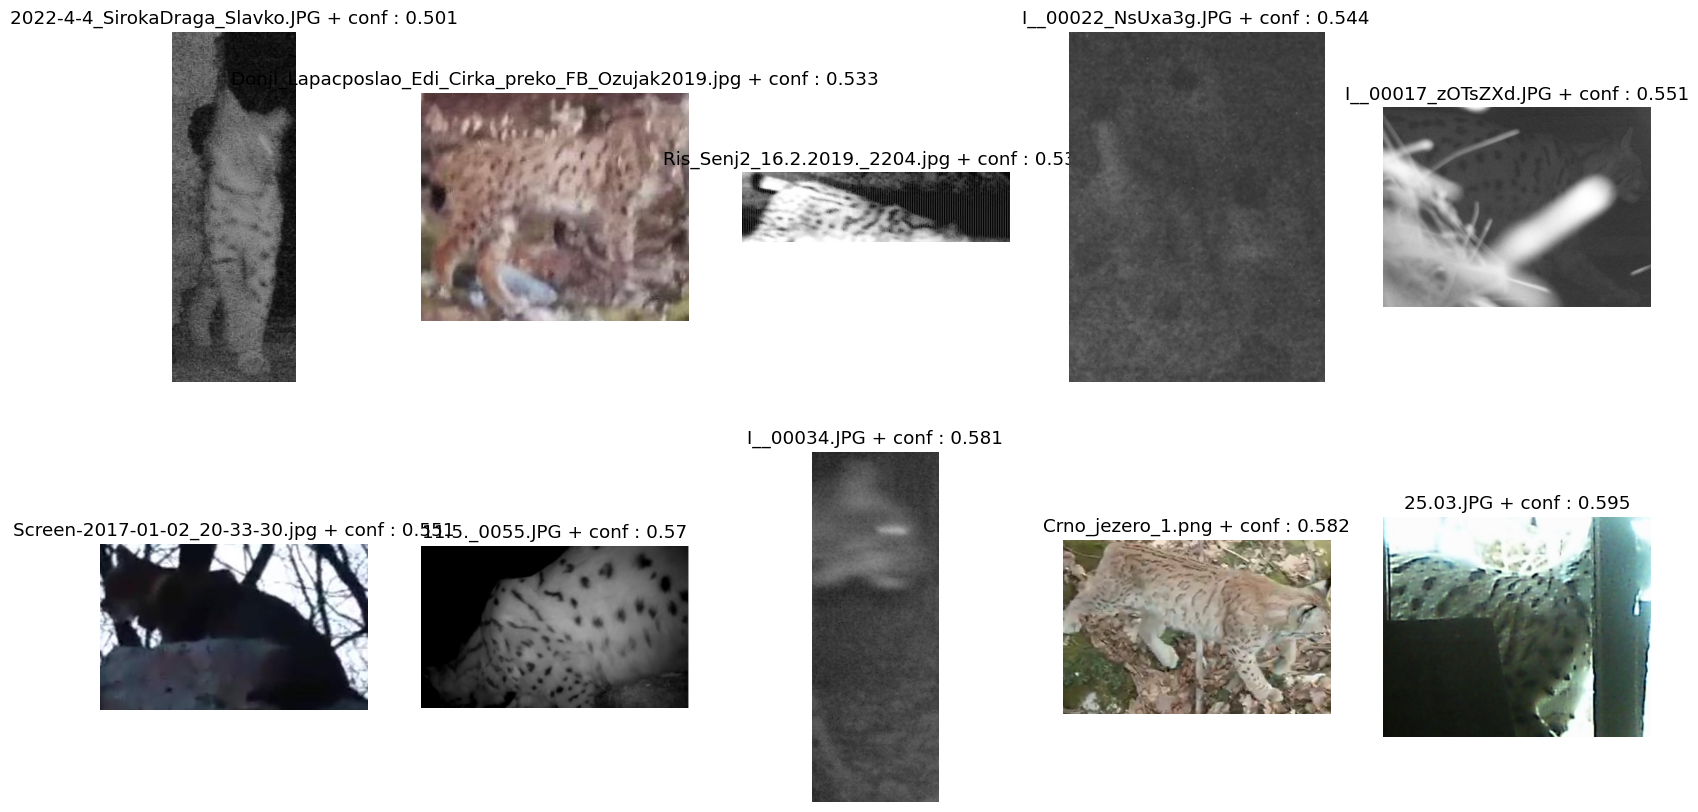

In [86]:
plot_images_conf(df_bbox_croatia_single_detection, by="smallest")

#### 10 images cropped with the largest confidence are displayed

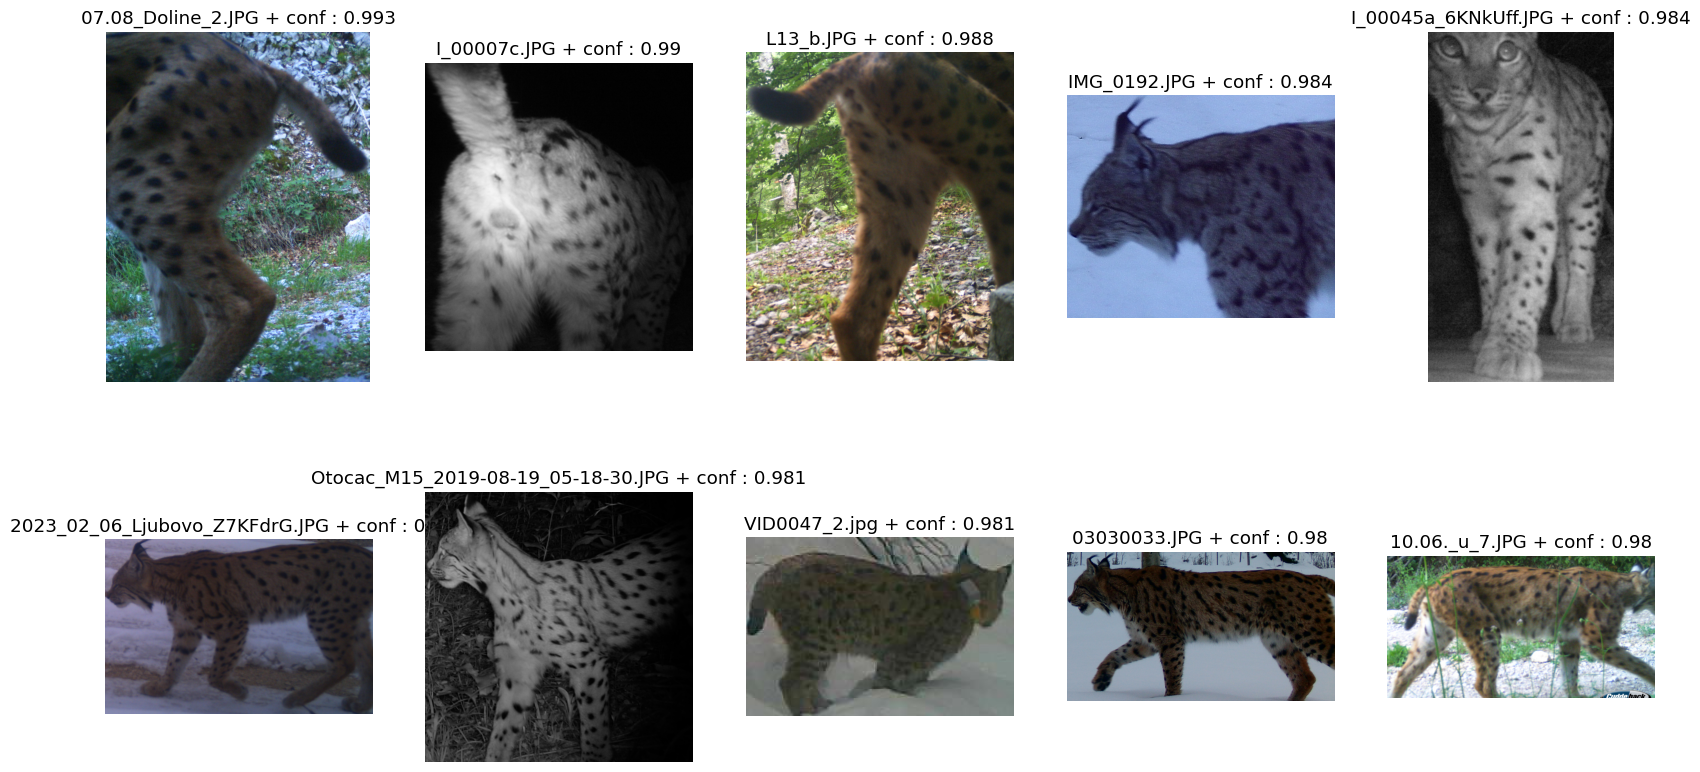

In [87]:
plot_images_conf(df_bbox_croatia_single_detection, by="largest")

In [88]:
df_croatia_with_bbox = pd.merge(df_croatia, df_bbox_croatia_single_detection[['file', 'conf', 'x', 'y', 'width', 'height']], how='inner', left_on='filepath', right_on='file')
df_croatia_with_bbox = df_croatia_with_bbox.drop('file', axis=1)

df_croatia_with_bbox

date  number_animals  number_children  \
0    2016-05-19 01:15:00               1                0   
1    2016-10-22 03:18:00               1                0   
2    2016-10-23 11:35:00               1                0   
3    2013-12-10 10:21:00               1                0   
4    2014-09-13 17:49:00               1                0   
...                  ...             ...              ...   
1658 2023-04-20 00:02:00               1                0   
1659 2023-05-11 12:40:00               1                0   
1660 2023-05-13 18:06:00               1                0   
1661 2022-04-05 05:31:00               1                0   
1662 2023-11-06 07:19:00               1                0   

                                               filepath        lynx_id  ...  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Varošina 2016  ...   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Goran ZIP L09  ...   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Goran ZIP L09  ...   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...        Pakleni  ...   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...            Nik  ...   
...                                                 ...            ...  ...   
1658  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35  ...   
1659  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35  ...   
1660  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35  ...   
1661  /gpfsscratch/rech/ads/commun/datasets/extracte...          Vilim  ...   
1662  /gpfsscratch/rech/ads/commun/datasets/extracte...  Crno jezero 2  ...   

       conf           x          y      width    height  
0     0.932  1068.94080   895.8000   440.8992  272.0000  
1     0.915   707.94240   645.8496   848.7424  551.8656  
2     0.944   197.99296   768.9792  1275.9296  761.7984  
3     0.822  1168.92160   702.8736   626.8416  245.8368  
4     0.936  1396.73600   874.7904   571.9296  660.8448  
...     ...         ...        ...        ...       ...  
1658  0.951   736.00000   483.9600   245.9200  255.9600  
1659  0.840   873.92000   438.0000   112.0000  327.0000  
1660  0.897   752.96000   486.0000   232.9600  248.8800  
1661  0.952   256.96000  1865.7000   734.8000  773.7000  
1662  0.924   665.98350   409.9440   362.9730  191.9365  

[1663 rows x 15 columns]

#### Bounding box confidence distribution

<Axes: xlabel='conf', ylabel='Count'>

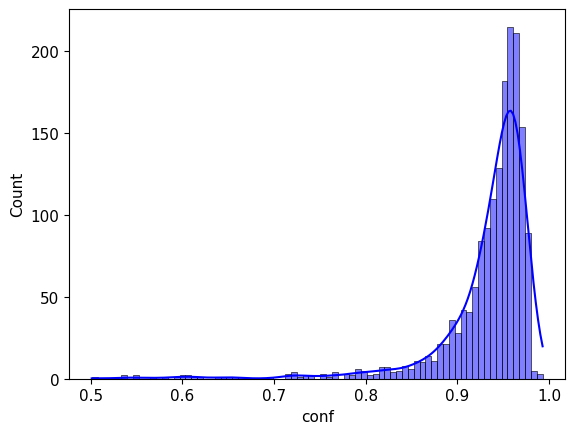

In [89]:
sns.histplot(df_croatia_with_bbox["conf"], kde=True, color='blue')

#### Compute `image_number` for each individual

This number is no longer the same as initially following filtering, particularly of images with no bounding box detected, for example.

In [90]:
df_croatia_with_bbox['image_number'] = df_croatia_with_bbox.groupby('lynx_id').cumcount() + 1
df_croatia_with_bbox

date  number_animals  number_children  \
0    2016-05-19 01:15:00               1                0   
1    2016-10-22 03:18:00               1                0   
2    2016-10-23 11:35:00               1                0   
3    2013-12-10 10:21:00               1                0   
4    2014-09-13 17:49:00               1                0   
...                  ...             ...              ...   
1658 2023-04-20 00:02:00               1                0   
1659 2023-05-11 12:40:00               1                0   
1660 2023-05-13 18:06:00               1                0   
1661 2022-04-05 05:31:00               1                0   
1662 2023-11-06 07:19:00               1                0   

                                               filepath        lynx_id  ...  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Varošina 2016  ...   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Goran ZIP L09  ...   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Goran ZIP L09  ...   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...        Pakleni  ...   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...            Nik  ...   
...                                                 ...            ...  ...   
1658  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35  ...   
1659  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35  ...   
1660  /gpfsscratch/rech/ads/commun/datasets/extracte...     Slavko L35  ...   
1661  /gpfsscratch/rech/ads/commun/datasets/extracte...          Vilim  ...   
1662  /gpfsscratch/rech/ads/commun/datasets/extracte...  Crno jezero 2  ...   

               x          y      width    height  image_number  
0     1068.94080   895.8000   440.8992  272.0000             1  
1      707.94240   645.8496   848.7424  551.8656             1  
2      197.99296   768.9792  1275.9296  761.7984             2  
3     1168.92160   702.8736   626.8416  245.8368             1  
4     1396.73600   874.7904   571.9296  660.8448             1  
...          ...        ...        ...       ...           ...  
1658   736.00000   483.9600   245.9200  255.9600            57  
1659   873.92000   438.0000   112.0000  327.0000            58  
1660   752.96000   486.0000   232.9600  248.8800            59  
1661   256.96000  1865.7000   734.8000  773.7000            88  
1662   665.98350   409.9440   362.9730  191.9365             8  

[1663 rows x 16 columns]

In [91]:
df_croatia_with_bbox.to_csv(CROATIAN_DATASET_PATH / "lynx_dataset_croatia.csv", index=False)

## **Merge the dataframes**

In [92]:
# Load them locally
france_dataset = pd.read_csv(DATASET / "france" / "lynx_dataset_france.csv")
croatia_dataset = pd.read_csv(DATASET / "croatia" / "lynx_dataset_croatia.csv")
slovenia_dataset = pd.read_csv(DATASET / "slovenia" / "lynx_dataset_slovenia.csv")

In [93]:
df_full = pd.concat([france_dataset, croatia_dataset, slovenia_dataset], ignore_index=True)
df_full

filepath   lynx_id source  \
0     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
1     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
2     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
3     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
4     /gpfsscratch/rech/ads/commun/datasets/extracte...  Van-Gogh    OCS   
...                                                 ...       ...    ...   
6694  /gpfsscratch/rech/ads/commun/datasets/extracte...      Goru    NaN   
6695  /gpfsscratch/rech/ads/commun/datasets/extracte...      Goru    NaN   
6696  /gpfsscratch/rech/ads/commun/datasets/extracte...      Goru    NaN   
6697  /gpfsscratch/rech/ads/commun/datasets/extracte...      Goru    NaN   
6698  /gpfsscratch/rech/ads/commun/datasets/extracte...      Goru    NaN   

     pattern                 date  ...   sex  side  latitude  longitude  \
0        NaN           2012-04-27  ...   NaN   NaN       NaN        NaN   
1        NaN           2012-05-05  ...   NaN   NaN       NaN        NaN   
2        NaN           2012-03-17  ...   NaN   NaN       NaN        NaN   
3        NaN           2012-03-16  ...   NaN   NaN       NaN        NaN   
4        NaN           2012-03-05  ...   NaN   NaN       NaN        NaN   
...      ...                  ...  ...   ...   ...       ...        ...   
6694     NaN  2022-10-09 22:18:00  ...  Male   NaN   45.7776    14.7349   
6695     NaN  2022-11-26 12:49:00  ...  Male   NaN   45.7510    14.7730   
6696     NaN  2023-04-17 14:59:00  ...  Male   NaN   45.7510    14.7730   
6697     NaN  2023-02-06 00:21:00  ...  Male   NaN   45.7776    14.7349   
6698     NaN  2023-04-13 03:45:00  ...  Male   NaN   45.7624    14.7829   

       country  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
6694  Slovenia  
6695  Slovenia  
6696  Slovenia  
6697  Slovenia  
6698  Slovenia  

[6699 rows x 19 columns]

In [95]:
df_full.to_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full.csv", index=False)

## **Remove backgrounds**

Images without backgrounds are calculated using the `Segment Anything Model`. These are saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/no_background`.  
The csv file is completed with a `filepath_no_bg` column and saved here: `/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_no_bg.csv`

Two cases:

**1. Images without background don't exist**

In [ ]:
from lynx_id.preprocess.remove_background import remove_bg

df = remove_bg()
df

  2%|▏         | 147/6699 [01:57<1:22:14,  1.33it/s, conf=0.963, filename=F39-061_OFB_OCELLES_2017-03-08_Syam_26.JPG, image_shape=(1536, 2048, 3)]                    

**2. Images without background already exist and you want to add the `filepath_no_bg` column to the csv.**

In [68]:
no_bg_dir = "/gpfsscratch/rech/ads/commun/datasets/extracted/no_background"

df_full['filepath_no_bg'] = df_full['filepath'].apply(lambda x: no_bg_dir + "/no_bg_" + os.path.basename(x))

In [69]:
all_files_exist = all(df_full['filepath_no_bg'].apply(os.path.exists))
assert all_files_exist is True

In [70]:
df_full.to_csv(DATASET / "lynx_dataset_full.csv", index=False)